# <center style="background-color:#6891e8;font-family:Garamond;color:white;font-size:100%;text-align:center;border-radius:0px;padding: 10px;">  Data Cleaning & Semi-Automatic Labelling  </center>

##### Ayetijhya Desmukhya, 465719

## Table of Contents

1. Exploring Dataset

2. Dataset Cleaning

3. Semi-Automatic Labelling using pre-trained models

4. Exploratory Data Analysis & Data Visualisation

# <center style="background-color:#6891e8;font-family:Garamond;color:white;font-size:100%;text-align:center;border-radius:0px;padding: 10px;"> 1. Exploring Dataset </center>

In [1]:
# Load libraries
import re
import torch
import random
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import pipeline
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
from concurrent.futures import ThreadPoolExecutor, as_completed
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Data Visualisation
import plotly.express as px
from dash import Dash, dcc, html, Input, Output
from PIL import Image

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
colour = '#6891e8'

In [3]:
# Data Loading
tweets = pd.read_excel('data/FilteredTweets_JanMarch2023.xlsx')
tweets.head()

,date,id,content,username,like_count,retweet_count
0,2023-03-29 22:49:41+00:00,1641210000000000000,Lots of teachers worrying about Chat GPT makin...,giordano_lives,1,0
1,2023-03-29 22:38:47+00:00,1641210000000000000,Can #ChatGPT really help create the new â€œSup...,Jonharper70bd,2,2
2,2023-03-29 22:38:25+00:00,1641210000000000000,@jdflynn @dr_t_teacher Is this ALSO Chat GPT?!...,KatyDornbos,0,0
3,2023-03-29 22:28:10+00:00,1641210000000000000,I asked Chat GPT why teachers are so underpaid...,NicholasFerroni,91,13
4,2023-03-29 21:34:35+00:00,1641190000000000000,One of my FAVE thought leaders to learn from i...,annkozma723,2,0


In [4]:
# Data Overview
print('Shape', tweets.shape, '\n')
print(tweets.info())

Shape (13401, 6) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13401 entries, 0 to 13400
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           13401 non-null  object
 1   id             13401 non-null  int64 
 2   content        13401 non-null  object
 3   username       13401 non-null  object
 4   like_count     13401 non-null  int64 
 5   retweet_count  13401 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 628.3+ KB
None


In [5]:
# Descriptive Statistics
print(tweets.describe())

                 id    like_count  retweet_count
count  1.340100e+04  13401.000000   13401.000000
mean   1.625093e+18      9.952168       1.517946
std    8.938203e+15    399.271748      16.013516
min    1.610540e+18      0.000000       0.000000
25%    1.617500e+18      0.000000       0.000000
50%    1.624070e+18      1.000000       0.000000
75%    1.633020e+18      3.000000       1.000000
max    1.641210e+18  44940.000000    1349.000000


In [6]:
# Average tweet length
print("Average length of tweet is:", tweets['content'].apply(len).mean())

Average length of tweet is: 217.85918961271548


In [7]:
# Counting the missing values
nans = tweets.isna().sum().sort_values(ascending = False)
pct = (nans/tweets.shape[0]) * 100
print(pd.concat([nans, pct], axis = 1).rename(columns = { 0 : 'NaN Values Count', 1 : 'NaN Values Percentage (%)'}).round(2))

               NaN Values Count  NaN Values Percentage (%)
date                          0                        0.0
id                            0                        0.0
content                       0                        0.0
username                      0                        0.0
like_count                    0                        0.0
retweet_count                 0                        0.0


In [8]:
# Checking for duplicated rows
tweets.duplicated().any()

False

# <center style="background-color:#6891e8;font-family:Garamond;color:white;font-size:100%;text-align:center;border-radius:0px;padding: 10px;"> 2. Data Cleaning </center>

In [9]:
# Change `date` to date (without time)
tweets['date'] = pd.to_datetime(tweets['date'])
tweets['date'] = tweets['date'].dt.date

print("Date Range: " ,tweets['date'].min(), "-" ,tweets['date'].max())

Date Range:  2023-01-04 - 2023-03-29


In [10]:
ENGLISH_STOP_WORDS = stopwords.words('english')

# Manually removing specific stopwords from the list
custom_ignore_stopwords = ['against', 'above', 'below', 'down', 'off', 'over', 'under', 'no', 'not', 'too', 'very']
custom_add_stopwords = ['amp', 'lt', 'gt', 'using']
ENGLISH_STOP_WORDS = [word for word in ENGLISH_STOP_WORDS if word not in custom_ignore_stopwords]
ENGLISH_STOP_WORDS.extend(custom_add_stopwords)

print(ENGLISH_STOP_WORDS)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'to', 'from', 'up', 'in', 'out', 'on', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'no

In the below `preprocess_text(text)` function we have tried to eliminate any jargon from the contents. It cleans and standardizes text data by first converting it to lowercase to ensure uniformity, removes retweet markers (e.g., "@username") to focus on the main content, eliminates non-alphabetic characters (such as punctuation and numbers), and splits the text into individual words through tokenization. The function then applies lemmatization to reduce words to their base forms (e.g., "running" becomes "run") and removes common stopwords that don't add meaningful information.

In [11]:
def preprocess_text(text):
    # Lower text
    text = text.lower()
    # Remove usernames (i.e., @usernames)
    text = re.sub(r'@\w+', '', text)
    # Remove URLs (links starting with http://, https:// or www)
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove hashtags
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    # Remove special characters, numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    #Lemmatization 
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in ENGLISH_STOP_WORDS]
    # Remove stopwords
    return ' '.join(tokens)

In [12]:
tweets['cleaned_content'] = tweets['content'].apply(preprocess_text)
tweets.head()

,date,id,content,username,like_count,retweet_count,cleaned_content
0,2023-03-29,1641210000000000000,Lots of teachers worrying about Chat GPT makin...,giordano_lives,1,0,lot teacher worrying chat gpt making essay wri...
1,2023-03-29,1641210000000000000,Can #ChatGPT really help create the new â€œSup...,Jonharper70bd,2,2,really help create new superteacher whats kryp...
2,2023-03-29,1641210000000000000,@jdflynn @dr_t_teacher Is this ALSO Chat GPT?!...,KatyDornbos,0,0,also chat gpt surely not true
3,2023-03-29,1641210000000000000,I asked Chat GPT why teachers are so underpaid...,NicholasFerroni,91,13,asked chat gpt teacher underpaid
4,2023-03-29,1641190000000000000,One of my FAVE thought leaders to learn from i...,annkozma723,2,0,one fave thought leader learn youre curious tr...


# <center style="background-color:#6891e8;font-family:Garamond;color:white;font-size:100%;text-align:center;border-radius:0px;padding: 10px;"> 3. Semi-Automatic Labelling </center>

One significant challenge I faced with this dataset is the absence of a dedicated column containing sentiment labels, such as positive, negative, or neutral. These labels are crucial for the classification process. While I could consider manually labeling the data, this approach is only feasible for smaller datasets due to the time and effort it requires. Therefore, opting for a semi-automatic labeling strategy, which is much more efficient for handling larger datasets was a better option.

Semi-automatic labeling is a process that combines automated methods and human supervision to annotate data for machine learning tasks. It aims to reduce the manual effort required for labeling large datasets while ensuring a high level of accuracy and reliability. In this approach, a model or algorithm generates initial labels or predictions, which are then reviewed and corrected by human annotators.

To implement this approach, a pre-trained sentiment analysis model - VADER was used to get the sentiment and categorize them into positive, neutral and negative.

In [14]:
# Initialize sentiment analysis pipelines with lightweight models
sid = SentimentIntensityAnalyzer()
# sentiment_pipeline_distilbert = pipeline("sentiment-analysis", model="distilbert-base-uncased")
# sentiment_pipeline_mobilebert = pipeline("sentiment-analysis", model="google/mobilebert-uncased")
# sentiment_pipeline_tinybert = pipeline("sentiment-analysis", model="huawei-noah/TinyBERT_General_4L_312D")
# sentiment_pipeline_albert = pipeline("sentiment-analysis", model="albert-base-v2")

# Function for batch processing
def batch_predict(texts, model, batch_size=16):
    predictions = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        try:
            results = model(batch)
            predictions.extend(results)
        except Exception as e:
            print(f"Error processing batch {i//batch_size}: {e}")
    return predictions

# Function to process batches in parallel using ThreadPoolExecutor
def parallel_sentiment_analysis(texts, model, batch_size=16):
    predictions = []
    with ThreadPoolExecutor() as executor:
        futures = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            futures.append(executor.submit(batch_predict, batch, model, batch_size))
        
        # Collect results as they are completed
        for future in tqdm(as_completed(futures), total=len(futures)):
            try:
                predictions.extend(future.result())
            except Exception as e:
                print(f"Error in processing batch: {e}")
    
    return predictions

# Apply sentiment analysis on the cleaned tweets using the modified functions
print('Starting Vader...')
tweets['sentiment'] = tweets['cleaned_content'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Additional models were employed in hopes of having a majority voting system to get 
# as close to the true value as possible, but unfortunately most of these models didn't
# perform well. Thus, dropping this idea.

# print('Starting DistilBERT...')
# tweets['sentiment_distilbert'] = parallel_sentiment_analysis(tweets['cleaned_content'].tolist(), sentiment_pipeline_distilbert)

# print('Starting MobileBERT...')
# tweets['sentiment_mobilebert'] = parallel_sentiment_analysis(tweets['cleaned_content'].tolist(), sentiment_pipeline_mobilebert)

# print('Starting TinyBERT...')
# tweets['sentiment_tinybert'] = parallel_sentiment_analysis(tweets['cleaned_content'].tolist(), sentiment_pipeline_tinybert)

# print('Starting ALBERT...')
# tweets['sentiment_albert'] = parallel_sentiment_analysis(tweets['cleaned_content'].tolist(), sentiment_pipeline_albert)
 
# Display a sample of the results
tweets.head()

Starting Vader...


,date,id,content,username,like_count,retweet_count,cleaned_content,sentiment
0,2023-03-29,1641210000000000000,Lots of teachers worrying about Chat GPT makin...,giordano_lives,1,0,lot teacher worrying chat gpt making essay wri...,-0.1531
1,2023-03-29,1641210000000000000,Can #ChatGPT really help create the new â€œSup...,Jonharper70bd,2,2,really help create new superteacher whats kryp...,0.8004
2,2023-03-29,1641210000000000000,@jdflynn @dr_t_teacher Is this ALSO Chat GPT?!...,KatyDornbos,0,0,also chat gpt surely not true,0.1451
3,2023-03-29,1641210000000000000,I asked Chat GPT why teachers are so underpaid...,NicholasFerroni,91,13,asked chat gpt teacher underpaid,0.0000
4,2023-03-29,1641190000000000000,One of my FAVE thought leaders to learn from i...,annkozma723,2,0,one fave thought leader learn youre curious tr...,0.6705


In [15]:
# VADER - Get the range of the sentiment column
sentiment_min = tweets['sentiment'].min()
sentiment_max = tweets['sentiment'].max()

print(f"Sentiment Range: {sentiment_min} to {sentiment_max}")

Sentiment Range: -0.9786 to 0.9808


In [16]:
# VADER - Categorize sentiment
# 2 - very positive > 0.6
# 1 - 0.6 > positive > 0.1 
# 0 - 0.1 > neutral > -0.1
# -1 - -0.1 > negative > -0.6
# -2 - -0.6 > very negative

# VADER sentiment categorization
tweets['sentiment'] = tweets['sentiment'].apply(
    lambda x: 2 if x > 0.6 else
    (1 if x > 0.1 else
    (0 if x > -0.1 else
    (-1 if x > -0.6 else -2))))

tweets.head()

,date,id,content,username,like_count,retweet_count,cleaned_content,sentiment
0,2023-03-29,1641210000000000000,Lots of teachers worrying about Chat GPT makin...,giordano_lives,1,0,lot teacher worrying chat gpt making essay wri...,-1
1,2023-03-29,1641210000000000000,Can #ChatGPT really help create the new â€œSup...,Jonharper70bd,2,2,really help create new superteacher whats kryp...,2
2,2023-03-29,1641210000000000000,@jdflynn @dr_t_teacher Is this ALSO Chat GPT?!...,KatyDornbos,0,0,also chat gpt surely not true,1
3,2023-03-29,1641210000000000000,I asked Chat GPT why teachers are so underpaid...,NicholasFerroni,91,13,asked chat gpt teacher underpaid,0
4,2023-03-29,1641190000000000000,One of my FAVE thought leaders to learn from i...,annkozma723,2,0,one fave thought leader learn youre curious tr...,2


# <center style="background-color:#6891e8;font-family:Garamond;color:white;font-size:100%;text-align:center;border-radius:0px;padding: 10px;"> 4. Exploratory Data Analysis & Data Visualisation </center>

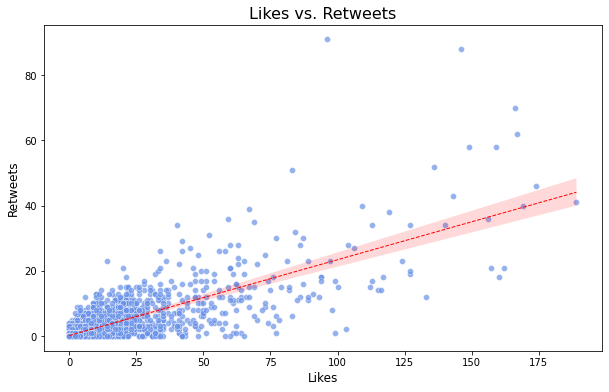

In [17]:
# Find relationship between `likes` and `retweets`

# Since we have a large dataset we will sample only a small portion of it
# by defining thresholds
like_count_max = 200
retweet_count_max = 100

filtered_tweets = tweets[(tweets['like_count'] <= like_count_max) 
                         & (tweets['retweet_count'] <= retweet_count_max)]

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='like_count', y='retweet_count', data=filtered_tweets, color=colour, alpha=0.7)
sns.regplot(x='like_count', y='retweet_count', data=filtered_tweets, scatter=False, color='red', line_kws={'lw': 1, 'ls': '--'})
plt.title('Likes vs. Retweets', fontsize=16)
plt.xlabel('Likes', fontsize=12)
plt.ylabel('Retweets', fontsize=12)
plt.show()

Thus, from the above graph, we can say that a high number of likes may bring in a high number of retweets and vice versa, as shown by the tight clustering around the regression line at lower values. However, at higher counts, the relationship becomes less consistent, with more scattered data points. Tweets with many likes often have a higher likelihood of being retweeted, but this trend is not uniform, as shown by the outliers.

The shaded red area around the regression line represents the confidence interval, suggesting the range within which most data points are expected to fall. It widens at higher values of likes, indicating greater variability in retweet counts for tweets with more likes.

In [18]:
# Time Analysis over days, weeks and months

tweets['date'] = pd.to_datetime(tweets['date'])

tweets['day'] = tweets['date'].dt.date
tweets['week'] = tweets['date'].dt.to_period('W').dt.start_time
tweets['month'] = tweets['date'].dt.to_period('M').dt.start_time

tweets_per_day = tweets.groupby('day').size().reset_index(name='tweets_per_day')
tweets_per_week = tweets.groupby('week').size().reset_index(name='tweets_per_week')
tweets_per_month = tweets.groupby('month').size().reset_index(name='tweets_per_month')

# Dash App Initialization
app = Dash(__name__)

app.layout = html.Div([
    html.H4("Tweets Over Time", style={'textAlign': 'center', 'fontFamily': 'Arial, sans-serif',}),
    
    html.Label("Select Time Period:", style={'fontFamily': 'Arial, sans-serif'}),
    html.Div(style={'height': '5px'}),
    dcc.RadioItems(
        id='time-period',
        options=[
            {'label': 'Day', 'value': 'day'},
            {'label': 'Week', 'value': 'week'},
            {'label': 'Month', 'value': 'month'},
        ],
        value='day',
        inline=True,
        style={'fontFamily': 'Arial, sans-serif'}
    ),
    html.Div(style={'height': '5px'}),
    dcc.Graph(id='bar-graph'),
])

# Callback for Dynamic Graph
@app.callback(
    Output('bar-graph', 'figure'),
    [Input('time-period', 'value')]
)
def update_graph(selected_period):
    if selected_period == 'day':
        df = tweets_per_day.rename(columns={'day': 'date', 'tweets_per_day': 'count'})
    elif selected_period == 'week':
        df = tweets_per_week.rename(columns={'week': 'date', 'tweets_per_week': 'count'})
    else:
        df = tweets_per_month.rename(columns={'month': 'date', 'tweets_per_month': 'count'})
    
    # Bar plot
    fig = px.bar(
        df, x='date', y='count',
        title=f'Number of Tweets per {selected_period.capitalize()}',
        labels={'date': 'Date', 'count': 'Number of Tweets'},
        template="plotly_white",
        color_discrete_sequence=[colour]
    )
    
    fig.update_layout(
        xaxis_title="Date",
        yaxis_title="Tweet Count",
        height=400,
        width=700
    )
    return fig

# Run app
if __name__ == '__main__':
    app.run_server(debug=True)


In [19]:
# Top hashtags
hashtags = tweets['content'].str.findall(r'#\w+')
hashtags_count = hashtags.explode().value_counts()
hashtags_count.head(30)

content
#ChatGPT                   9147
#AI                        3232
#education                 2593
#chatgpt                   1939
#edtech                    1098
#ai                         773
#ArtificialIntelligence     658
#Education                  646
#OpenAI                     429
#teachers                   394
#highereducation            387
#chatGPT                    376
#edchat                     328
#EdTech                     327
#technology                 302
#teaching                   274
#learning                   264
#artificialintelligence     236
#chatbot                    205
#teacher                    202
#edutech                    199
#teachertwitter             198
#AIinEducation              174
#openai                     168
#tech                       162
#highered                   161
#MachineLearning            158
#students                   145
#onlinelearning             144
#google                     143
Name: count, dtype: int64

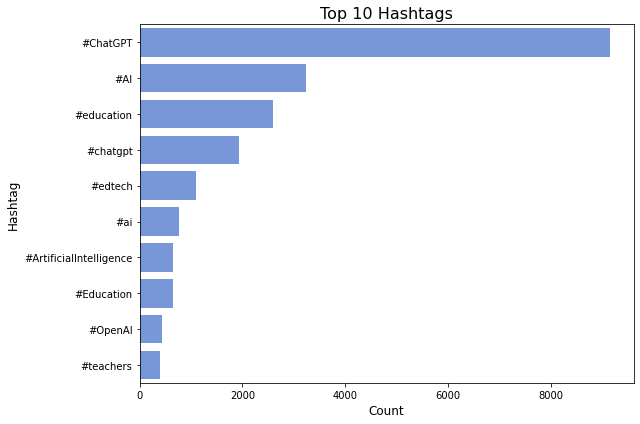

In [20]:
# Get top 10 hashtags to visualise
top_10_hashtags = hashtags_count.head(10)

plt.figure(figsize=(9, 6))
sns.barplot(x=top_10_hashtags.values, y=top_10_hashtags.index, color=colour) 
plt.title('Top 10 Hashtags', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Hashtag', fontsize=12)
plt.tight_layout()
plt.show()


In [21]:
# Sentiment Visualisation

# Checking the distribution of sentiment categories
sentiment_counts = tweets['sentiment'].value_counts()
sentiment_counts_df = sentiment_counts.reset_index()
sentiment_counts_df.columns = ['Sentiment Category', 'Number of Reviews']
sentiment_counts_df

,Sentiment Category,Number of Reviews
0,1,4134
1,0,3650
2,2,3475
3,-1,1663
4,-2,479


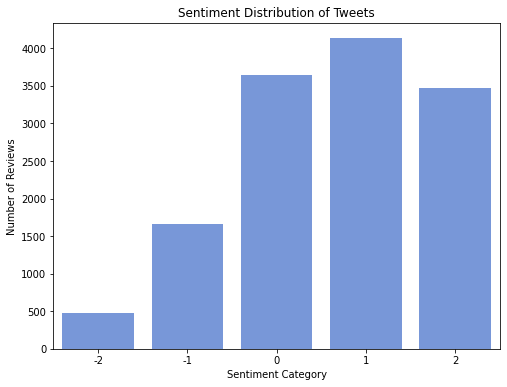

In [22]:
# Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.barplot(data=sentiment_counts_df, x='Sentiment Category', y='Number of Reviews', color=colour)
plt.title('Sentiment Distribution of Tweets')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Reviews')
plt.show()

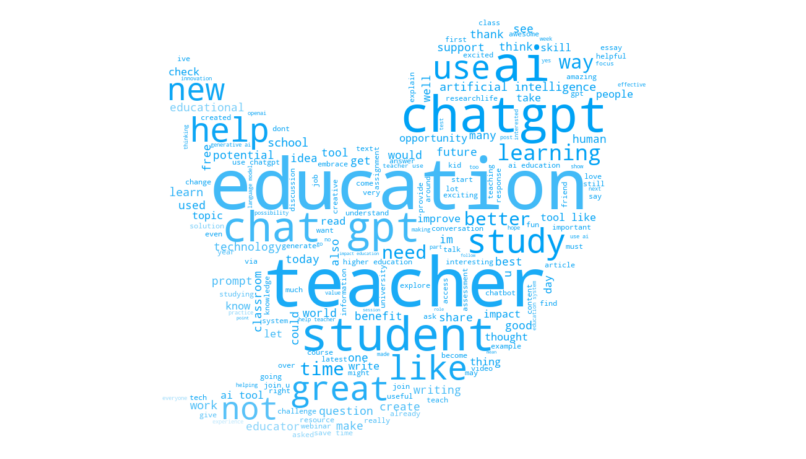

In [23]:
# Visualise most common positive words in tweets

mask = np.array(Image.open("data/twitter_logo.png").convert("RGB"))

df = tweets[tweets['sentiment']==2]
words = ' '.join(df['cleaned_content'])

stopwords = set(ENGLISH_STOP_WORDS)

wordcloud = WordCloud(stopwords=stopwords,
                      background_color='white',
                      mode="RGBA",
                      width=4000,
                      height=3000,
                      max_words=200,
                      mask=mask
                     ).generate(words)

image_colors = ImageColorGenerator(mask)
plt.figure(1,figsize=(11, 13))
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.show()

In [24]:
# Display the positive words with their frequency
word_frequencies = wordcloud.words_
top_10_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:20]
for word, freq in top_10_words:
    print(f'{word}: {freq}')

education: 1.0
teacher: 0.9280487804878049
chatgpt: 0.7
ai: 0.6707317073170732
student: 0.6146341463414634
chat gpt: 0.5841463414634146
great: 0.36097560975609755
study: 0.3548780487804878
help: 0.3524390243902439
like: 0.35121951219512193
use: 0.32439024390243903
new: 0.3170731707317073
not: 0.3170731707317073
learning: 0.31585365853658537
way: 0.24878048780487805
time: 0.2304878048780488
better: 0.2280487804878049
need: 0.22560975609756098
artificial intelligence: 0.22317073170731708
learn: 0.22195121951219512


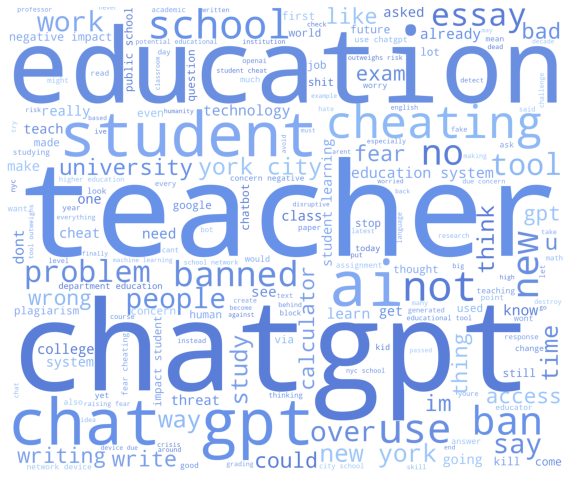

In [25]:
# Visualise most common negative words in tweets
df = tweets[tweets['sentiment']==-2]
words = ' '.join(df['cleaned_content'])

color_palette = ['#6891e8', '#5a7dd7', '#7a9fe9', '#83a9f2', '#8db9f5', '#9cc6f8', '#6a8fe1']
def random_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(color_palette)


wordcloud = WordCloud(stopwords=stopwords,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(words)

wordcloud = wordcloud.recolor(color_func=random_color_func)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [26]:
# Display the positive words with their frequency
word_frequencies = wordcloud.words_
top_10_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:20]
for word, freq in top_10_words:
    print(f'{word}: {freq}')

teacher: 1.0
chatgpt: 0.9166666666666666
education: 0.717948717948718
chat gpt: 0.6923076923076923
ai: 0.6666666666666666
student: 0.6410256410256411
cheating: 0.48717948717948717
not: 0.41025641025641024
use: 0.391025641025641
school: 0.3782051282051282
ban: 0.36538461538461536
new: 0.3333333333333333
no: 0.30128205128205127
banned: 0.28205128205128205
essay: 0.23717948717948717
problem: 0.21153846153846154
tool: 0.21153846153846154
work: 0.1794871794871795
over: 0.1794871794871795
people: 0.1794871794871795


From this point on, we will consider the `sentiment` column to be the true target value for our tweets. These values have been carefully reviewed from a human perspective and updated when the sentiment did not align with the tweet.

##### Preparing data for next stages

In [27]:
# Now we will drop irrelevant columns 
tweets = tweets.drop(columns=['id', 'date', 'username', 'like_count', 'retweet_count', 'day', 'week', 'month'], axis=1)
tweets.head(10)

,content,cleaned_content,sentiment
0,Lots of teachers worrying about Chat GPT makin...,lot teacher worrying chat gpt making essay wri...,-1
1,Can #ChatGPT really help create the new â€œSup...,really help create new superteacher whats kryp...,2
2,@jdflynn @dr_t_teacher Is this ALSO Chat GPT?!...,also chat gpt surely not true,1
3,I asked Chat GPT why teachers are so underpaid...,asked chat gpt teacher underpaid,0
4,One of my FAVE thought leaders to learn from i...,one fave thought leader learn youre curious tr...,2
5,Teachers: discussing #ChatGPT &amp; how to com...,teacher discussing combat classroom leader won...,-1
6,absolutely obsessed with my sociology teacher ...,absolutely obsessed sociology teacher chat gpt...,-1
7,â€œAfter spending 100s of hours\n\nIâ€™ve foun...,spending hour ive found secret us gpt prompt l...,1
8,This cool! Starting my new teacher newsletter ...,cool starting new teacher newsletter april top...,2
9,ChatGPT teacher warns pupils not to use AI\n h...,chatgpt teacher warns pupil not use ai,-1


In [29]:
# Save to CSV for modelling purposes in the next notebook
tweets.to_csv("data/RefinedTweets_JanMarch2023.csv", index=False)